### Time Series: Modeling
`Corey Solitaire`   
10/30/2020

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

from acquire import get_store_data, opsd_germany_daily
from prepare import prepped_store_df, prepped_energy_df

***

# Wrangle:

***

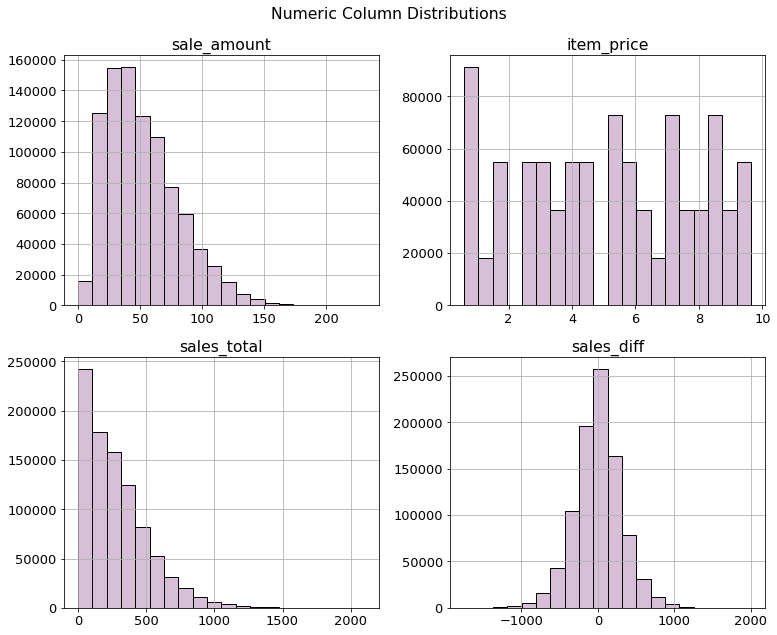

In [2]:
# Acquire and Prepare Data
df = get_store_data()
df = prepped_store_df(df)

In [3]:
# Resample by Day
df = df.resample('D').sum()
df.head()

,sale_amount,item_price,sales_total,sales_diff
sale_date,,,,
2013-01-01 00:00:00+00:00,13696.0,2580.2,73844.01,200.06
2013-01-02 00:00:00+00:00,13678.0,2580.2,73570.58,41.58
2013-01-03 00:00:00+00:00,14488.0,2580.2,78169.48,-185.35
2013-01-04 00:00:00+00:00,15677.0,2580.2,84467.73,73.19
2013-01-05 00:00:00+00:00,16237.0,2580.2,87621.85,-129.48


In [4]:
df.shape

(1826, 4)

In [5]:
# Rename sale_amount to make it easier to understand
df.rename(columns = {'sale_amount':'items_sold', 'sales_total':'dollars_sold'}, inplace = True)
df.drop(columns = ['item_price'],inplace = True)
df.head()

,items_sold,dollars_sold,sales_diff
sale_date,,,
2013-01-01 00:00:00+00:00,13696.0,73844.01,200.06
2013-01-02 00:00:00+00:00,13678.0,73570.58,41.58
2013-01-03 00:00:00+00:00,14488.0,78169.48,-185.35
2013-01-04 00:00:00+00:00,15677.0,84467.73,73.19
2013-01-05 00:00:00+00:00,16237.0,87621.85,-129.48


In [6]:
df = df[df.index != '2016-02-29']

***

# Explore:

***

#### Split:

1. We will use the training proprtion method to split   
2. Identify lenght of df, mult by `train_prop` to get the number of rows. `x = train_prop * 100`
3. Select row indicies
4. Return train and test dataframes

In [7]:
train_size = int(len(df)*.5)
train_size

912

In [8]:
validate_size = int(len(df)*.3)
validate_size

547

In [9]:
test_size = int(len(df) - train_size - validate_size)
test_size

366

In [10]:
validate_end_index = train_size + validate_size
validate_end_index

1459

`Use values to split dataframe`

In [11]:
train = df[:train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

***

***

#### Verify Splits

`Does the length of each df equate to the length of the original df?`

In [12]:
print(len(train) + len(validate) + len(test) == len(df))

True


`Does the first row of original df equate to the first row of train?`

In [13]:
print(df.head(1) == train.head(1))

                           items_sold  dollars_sold  sales_diff
sale_date                                                      
2013-01-01 00:00:00+00:00        True          True        True


`Is the last row of train the day before the first row of validate? And the same for validate to test?`

In [14]:
pd.concat([train.tail(1), validate.head(1)])

,items_sold,dollars_sold,sales_diff
sale_date,,,
2015-07-01 00:00:00+00:00,30703.0,164573.20,106.85
2015-07-02 00:00:00+00:00,33134.0,178036.64,-208.56


In [15]:
pd.concat([validate.tail(1), test.head(1)])

,items_sold,dollars_sold,sales_diff
sale_date,,,
2016-12-30 00:00:00+00:00,22296.0,120033.64,-213.08
2016-12-31 00:00:00+00:00,23792.0,128009.31,308.13


`Is the last row of test the same as the last row of our original dataframe?`

In [16]:
pd.concat([test.tail(1), df.tail(1)])

,items_sold,dollars_sold,sales_diff
sale_date,,,
2017-12-31 00:00:00+00:00,26420.0,140905.74,217.15
2017-12-31 00:00:00+00:00,26420.0,140905.74,217.15


`Let's plot our data first, viewing where the data is split into train and test.`

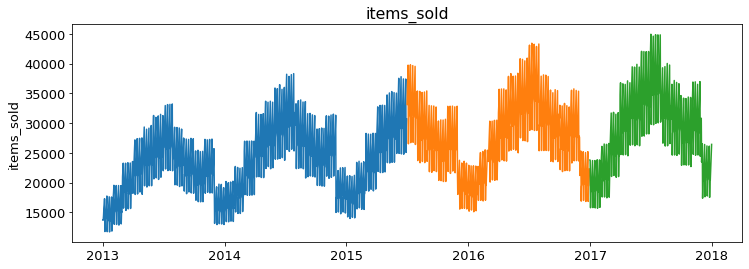

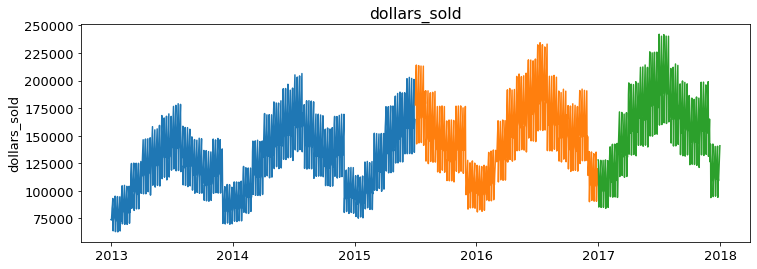

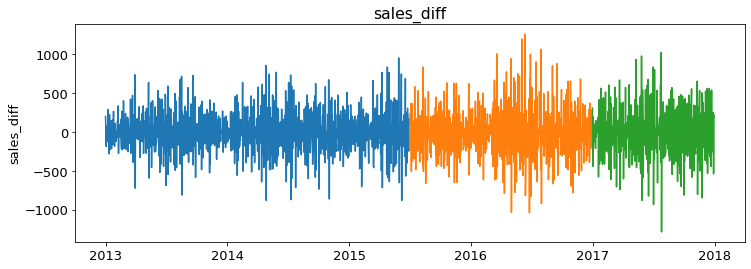

In [17]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow.

evaluate() will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.

In [18]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

plot_and_eval() will use the evaluate function and also plot train and test values with the predicted values in order to compare performance.

In [19]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

Write append_eval_df(model_type) to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our eval_df data frame object. Which we will create an empty eval_df dataframe object to start.

In [20]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [21]:
eval_df

,model_type,target_var,rmse


<div class="alert alert-block alert-info"><b></b></div>

***

# Forecast

Forecasting is another word for predicting time series data.

    Last Observed Value
    Simple Average
    Moving Average
    Holt's Linear Trend
    Previous Cycle
    
***

<div class="alert alert-block alert-info"><b></b></div>

## Last observed value

- The simplest method for forecasting is to predict all future values to be the last observed value.

<div class="alert alert-block alert-info"><b></b></div>

#### Make Predictions

In [22]:
# Dollar Prediction
dollars = round(train['dollars_sold'][-1:][0], 2)
dollars

164573.2

In [23]:
# Item Prediction
items = train['items_sold'][-1:][0]
items

30703.0

In [24]:
# sales_diff Prediction
s_diff = train['sales_diff'][-1:][0]
s_diff

106.84999999999988

In [25]:
yhat_df = pd.DataFrame({'dollars_sold': [dollars], 
                        'items_sold': [items],
                        'sales_diff': [s_diff]},
                      index = validate.index)

yhat_df.head()
yhat_df.describe()

,dollars_sold,items_sold,sales_diff
count,5.470000e+02,547.0,5.470000e+02
mean,1.645732e+05,30703.0,1.068500e+02
std,1.660437e-09,0.0,9.245511e-13
min,1.645732e+05,30703.0,1.068500e+02
25%,1.645732e+05,30703.0,1.068500e+02
50%,1.645732e+05,30703.0,1.068500e+02
75%,1.645732e+05,30703.0,1.068500e+02
max,1.645732e+05,30703.0,1.068500e+02


`You can see, when peeking into yhat_df, that every predicted value is the same.`

#### Plot Actual vs. Predicted Values

items_sold -- RMSE: 6621


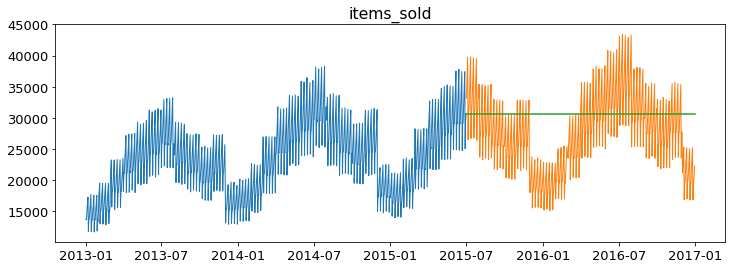

dollars_sold -- RMSE: 35402


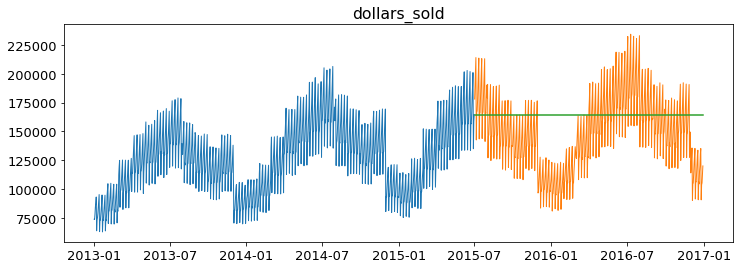

sales_diff -- RMSE: 348


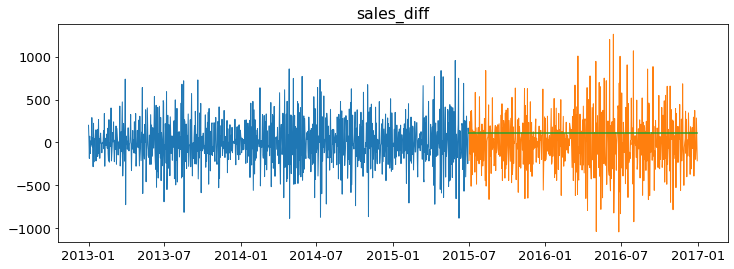

In [26]:
# Use Function to loop through columns

for col in train.columns:
    plot_and_eval(col)

#### Evaluate

Evaluate using MSE and RMSE, and add evaluation metrics to eval_df


In [27]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,items_sold,6621.0
1,last_observed_value,dollars_sold,35402.0
2,last_observed_value,sales_diff,348.0


<div class="alert alert-block alert-info"><b></b></div>

## Simple Average

Take the simple average of historical values and use that value to predict future values.

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train.

<div class="alert alert-block alert-info"><b></b></div>

#### Make Predictions

Dollars: establishing the value of the prediction we will make

In [28]:
# compute simple average: Dollars

# plt.plot(train['dollars_sold'])
dollars = round(train['dollars_sold'].mean(),2)
dollars

127517.85

In [29]:
# compute simple average: Items

items = round(train['items_sold'].mean(),2)
items

23717.94

In [30]:
# compute simple average: Sales_diff

s_diff = round(train['sales_diff'].mean(),2)
s_diff

0.36

#### Apply predictions to our observations

In [31]:
def make_predictions():
    yhat_df = pd.DataFrame({'dollars_sold': [dollars], 
                        'items_sold': [items],
                        'sales_diff': [s_diff]},
                      index = validate.index)
    return yhat_df

In [32]:
yhat_df = make_predictions()
yhat_df.head()

,dollars_sold,items_sold,sales_diff
sale_date,,,
2015-07-02 00:00:00+00:00,127517.85,23717.94,0.36
2015-07-03 00:00:00+00:00,127517.85,23717.94,0.36
2015-07-04 00:00:00+00:00,127517.85,23717.94,0.36
2015-07-05 00:00:00+00:00,127517.85,23717.94,0.36
2015-07-06 00:00:00+00:00,127517.85,23717.94,0.36


In [33]:
yhat_df.describe()

,dollars_sold,items_sold,sales_diff
count,5.470000e+02,5.470000e+02,5.470000e+02
mean,1.275179e+05,2.371794e+04,3.600000e-01
std,7.865227e-10,6.918487e-11,4.444957e-15
min,1.275179e+05,2.371794e+04,3.600000e-01
25%,1.275179e+05,2.371794e+04,3.600000e-01
50%,1.275179e+05,2.371794e+04,3.600000e-01
75%,1.275179e+05,2.371794e+04,3.600000e-01
max,1.275179e+05,2.371794e+04,3.600000e-01


#### Plot Actual vs. Predicted Values

Now, let's plot and evaluate the performance of our time series model using **Simple Average**


items_sold -- RMSE: 7378


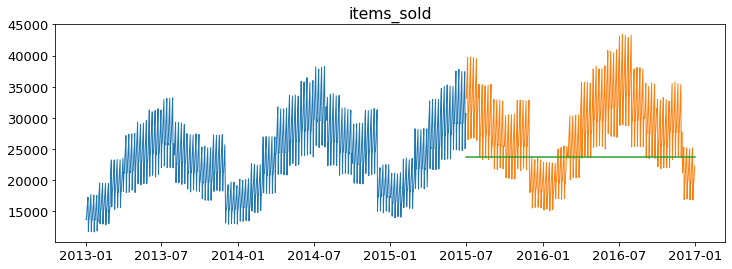

dollars_sold -- RMSE: 39664


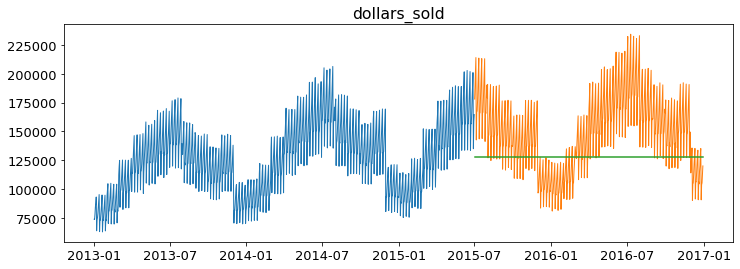

sales_diff -- RMSE: 332


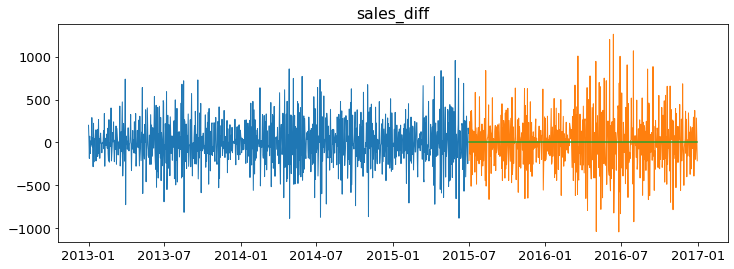

In [34]:
for col in train.columns:
    plot_and_eval(col)

#### Evaluate

Evaluate using MSE and RMSE, and add evaluation metrics to eval_df


In [35]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,items_sold,6621.0
1,last_observed_value,dollars_sold,35402.0
2,last_observed_value,sales_diff,348.0
3,simple_average,items_sold,7378.0
4,simple_average,dollars_sold,39664.0
5,simple_average,sales_diff,332.0


<div class="alert alert-block alert-info"><b></b></div>

## Moving Average

In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value.


<div class="alert alert-block alert-info"><b></b></div>

In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value.

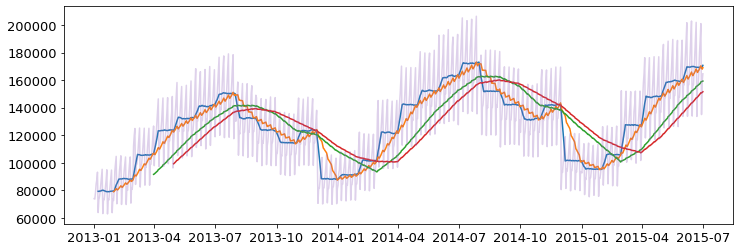

In [36]:
# train['dollars_sold'].tail(30)
plt.figure(figsize=(12,4))
plt.plot(train['dollars_sold'].rolling(7).mean())
plt.plot(train['dollars_sold'].rolling(30).mean())
plt.plot(train['dollars_sold'].rolling(90).mean())
plt.plot(train['dollars_sold'].rolling(120).mean())
plt.plot(train['dollars_sold'], alpha=.3)
plt.show()

In [37]:
# demonstrate that the mean of the first 30 days 
# is equal to rolling(30) on day 30

print(train['dollars_sold'].rolling(30).mean()[29])
print(train['dollars_sold'].head(30).mean())

78937.69766666666
78937.69766666666


#### Make Predictions

In [38]:
period = 30 

dollars = round(train['dollars_sold'].rolling(period).mean()[-1], 2)
items = round(train['items_sold'].rolling(period).mean()[-1], 2)
s_diff= round(train['sales_diff'].rolling(period).mean()[-1], 2)

print(dollars, items, s_diff)

168957.91 31432.77 -1.85


In [39]:
yhat_df = make_predictions()
yhat_df.head()

,dollars_sold,items_sold,sales_diff
sale_date,,,
2015-07-02 00:00:00+00:00,168957.91,31432.77,-1.85
2015-07-03 00:00:00+00:00,168957.91,31432.77,-1.85
2015-07-04 00:00:00+00:00,168957.91,31432.77,-1.85
2015-07-05 00:00:00+00:00,168957.91,31432.77,-1.85
2015-07-06 00:00:00+00:00,168957.91,31432.77,-1.85


#### Plot Actual vs. Predicted Values

Now, let's plot and evaluate the performance of our time series model using **Moving Average**


items_sold -- RMSE: 6954


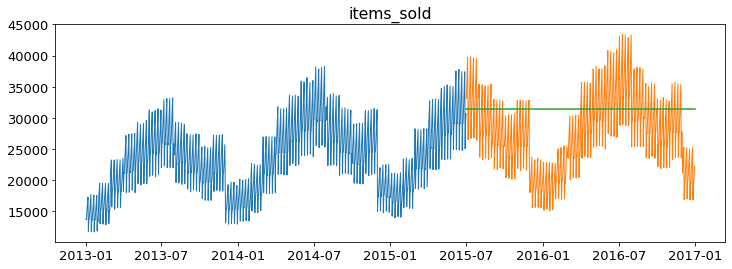

dollars_sold -- RMSE: 37378


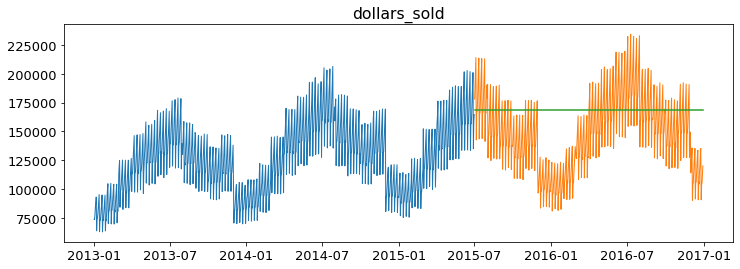

sales_diff -- RMSE: 332


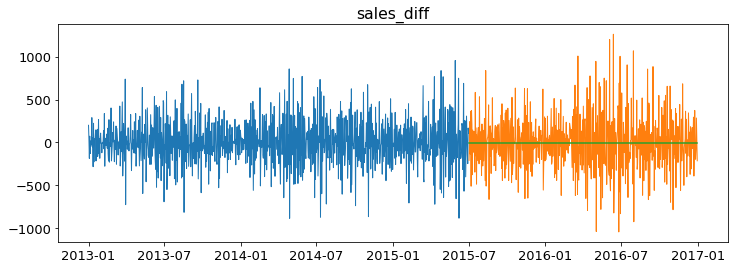

In [40]:
for col in train.columns:
    plot_and_eval(col)

#### Evaluate

Evaluate using MSE and RMSE, and add evaluation metrics to eval_df

In [41]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '30d_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,items_sold,6621.0
1,last_observed_value,dollars_sold,35402.0
2,last_observed_value,sales_diff,348.0
3,simple_average,items_sold,7378.0
4,simple_average,dollars_sold,39664.0
5,simple_average,sales_diff,332.0
6,30d_moving_avg,items_sold,6954.0
7,30d_moving_avg,dollars_sold,37378.0
8,30d_moving_avg,sales_diff,332.0


`Let's try out several other values for periods:`

In [42]:
periods = [1, 4, 12, 26, 52, 104]

for p in periods: 
    dollars = round(train['dollars_sold'].rolling(p).mean()[-1], 2)
    items = round(train['items_sold'].rolling(p).mean()[-1],2)
    yhat_df = make_predictions()
    model_type = str(p) + 'd_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type, 
                                 target_var = col)

In [43]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,items_sold,6621.0
1,last_observed_value,dollars_sold,35402.0
2,last_observed_value,sales_diff,348.0
3,simple_average,items_sold,7378.0
4,simple_average,dollars_sold,39664.0
5,simple_average,sales_diff,332.0
6,30d_moving_avg,items_sold,6954.0
7,30d_moving_avg,dollars_sold,37378.0
8,30d_moving_avg,sales_diff,332.0
9,1d_moving_avg,items_sold,6621.0


***

**Which is best so far?**

***

In [44]:
min_items_rmse = eval_df[eval_df.target_var == 'items_sold']['rmse'].min()

eval_df[eval_df.rmse == min_items_rmse]

,model_type,target_var,rmse
24,104d_moving_avg,items_sold,6101.0


<div class="alert alert-block alert-info"><b></b></div>


## Holt's Linear Trend

Exponential smoothing applied to both the average and the trend (slope).

 $alpha$  | smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.

 $beta$   | smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values.


<div class="alert alert-block alert-info"><b></b></div>

#### Seasonal Decomposition

First, let's take a look at the seasonal decomposition for each target.

items_sold 



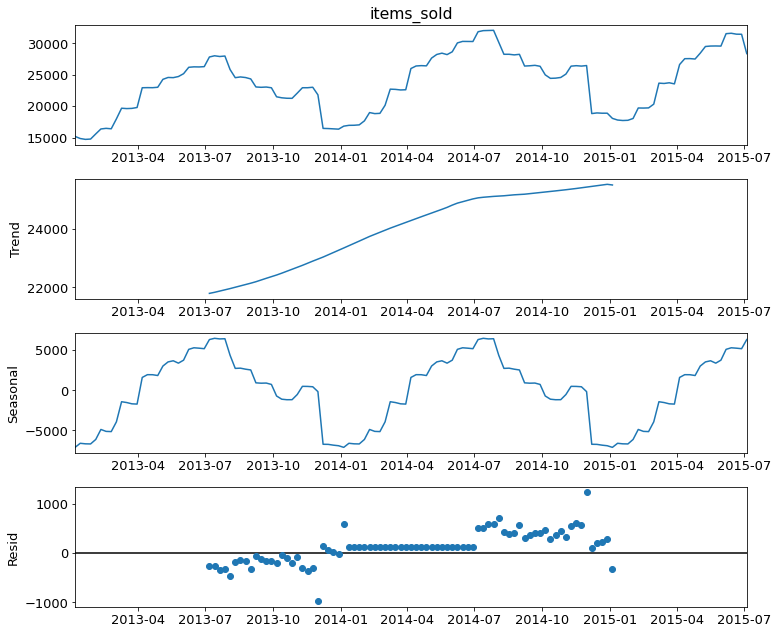

dollars_sold 



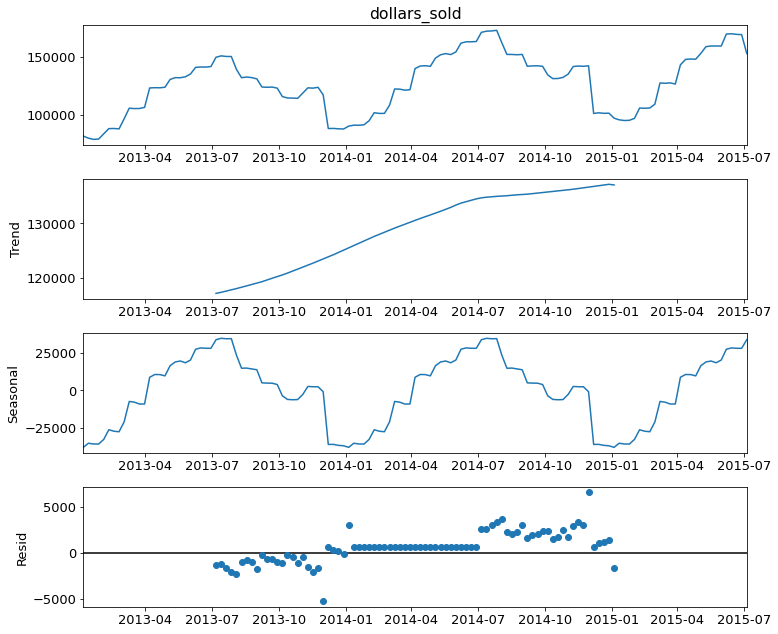

sales_diff 



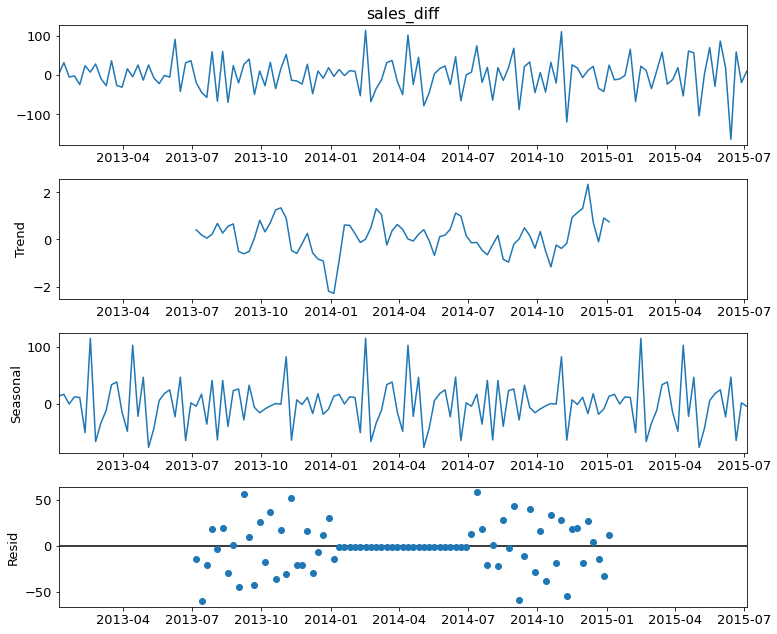

In [45]:
for col in train.columns:
    print(col, '\n')
    sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
    plt.show()


#### Basic Holt's Linear Trend

**Make Predictions**

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions.

Holt:

    - exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)

fit:

    - smoothing_level (alpha): value between (0,1)
    - smoothing_slope (beta): value between (0,1)



In [46]:
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_items = model.predict(start = validate.index[0],
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

In [47]:
yhat_df.head()

,dollars_sold,items_sold,sales_diff
sale_date,,,
2015-07-02 00:00:00+00:00,170207.53,31656.49,8.06
2015-07-03 00:00:00+00:00,170328.01,31678.93,9.91
2015-07-04 00:00:00+00:00,170447.29,31701.15,11.75
2015-07-05 00:00:00+00:00,170565.37,31723.15,13.56
2015-07-06 00:00:00+00:00,170682.27,31744.93,15.36


#### Plot Actual vs. Predicted Values


items_sold -- RMSE: 8225


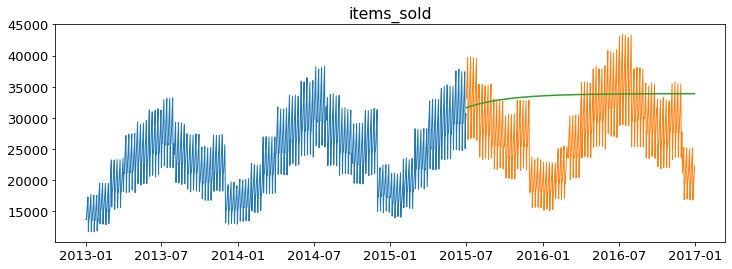

dollars_sold -- RMSE: 44226


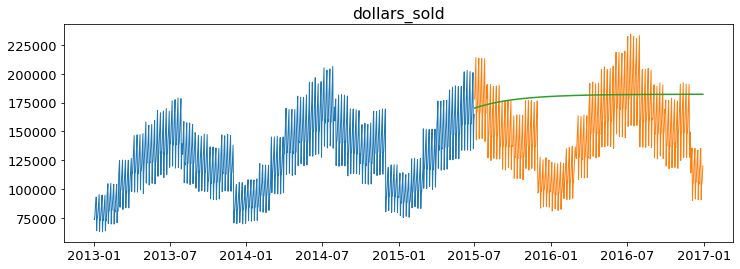

sales_diff -- RMSE: 371


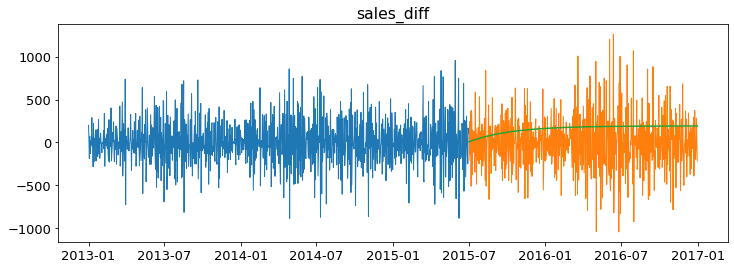

In [48]:
for col in train.columns:
    plot_and_eval(target_var = col)

#### Evaluate

In [49]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [50]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
14,4d_moving_avg,sales_diff,332.0
26,104d_moving_avg,sales_diff,332.0
23,52d_moving_avg,sales_diff,332.0
20,26d_moving_avg,sales_diff,332.0
5,simple_average,sales_diff,332.0
17,12d_moving_avg,sales_diff,332.0
11,1d_moving_avg,sales_diff,332.0
8,30d_moving_avg,sales_diff,332.0
2,last_observed_value,sales_diff,348.0
29,holts_optimized,sales_diff,371.0


<div class="alert alert-block alert-info"><b></b></div>

### Predict Based on Previous Cycle

Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day.

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence.

In the below example:

    Compute the 365 average year over year differences from 2013 through 2015
    Add that average delta to the values during 2015.
    Set the index in your yhat dataframe to represent the dates those predictions are make for.

Let's get started....

<div class="alert alert-block alert-info"><b></b></div>

#### Re-split data

In [51]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()

(1095, 3)
(365, 3)
(365, 3)


,items_sold,dollars_sold,sales_diff
sale_date,,,
2013-01-01 00:00:00+00:00,13696.0,73844.01,200.06
2013-01-02 00:00:00+00:00,13678.0,73570.58,41.58
2013-01-03 00:00:00+00:00,14488.0,78169.48,-185.35
2013-01-04 00:00:00+00:00,15677.0,84467.73,73.19
2013-01-05 00:00:00+00:00,16237.0,87621.85,-129.48


#### Make Predictions

In [52]:
# finding the year-over-year difference for each day from 2013 to 2015
# taking the mean, and then adding that value to the daily 2015 values. 

yhat_df = train['2015'] + train.diff(365).mean()

In [53]:
# let's peek into the prediction we will make for 1/1/2016
# by comparing the predicted value 
# (2015 value + year-over-year average difference)
# to the actual 1/1/2016 value
pd.concat([yhat_df.head(1), validate.head(1)])

,items_sold,dollars_sold,sales_diff
sale_date,,,
2015-01-01 00:00:00+00:00,19411.813699,104337.620493,-31.354068
2016-01-01 00:00:00+00:00,20158.000000,107875.260000,282.090000


In [54]:
# set yhat_df to index of validate

yhat_df.index = validate.index

yhat_df.describe()

,items_sold,dollars_sold,sales_diff
count,365.000000,365.000000,365.000000
mean,28314.271233,152236.991370,-0.368014
std,5816.407123,31264.033981,286.379908
min,16153.813699,87009.270493,-881.874068
25%,23977.813699,128679.520493,-175.434068
50%,27913.813699,150024.320493,-4.274068
75%,33022.813699,177535.990493,177.395932
max,41979.813699,225791.620493,954.765932


In [55]:
yhat_df.head()

,items_sold,dollars_sold,sales_diff
sale_date,,,
2016-01-01 00:00:00+00:00,19411.813699,104337.620493,-31.354068
2016-01-02 00:00:00+00:00,20904.813699,112870.770493,-8.104068
2016-01-03 00:00:00+00:00,21983.813699,118245.300493,-44.004068
2016-01-04 00:00:00+00:00,23286.813699,125496.760493,153.525932
2016-01-05 00:00:00+00:00,16420.813699,88551.940493,-183.074068


In [56]:
yhat_df.shape

(365, 3)

#### Plot and Evaluate

items_sold -- RMSE: 5223


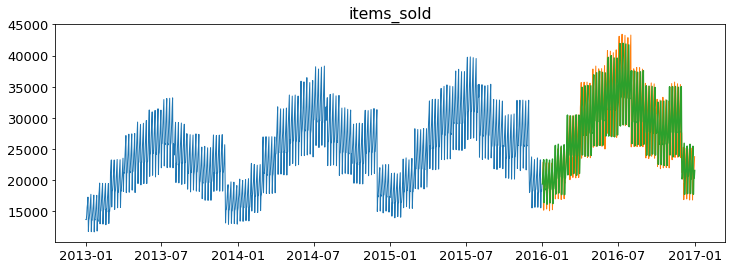

dollars_sold -- RMSE: 28087


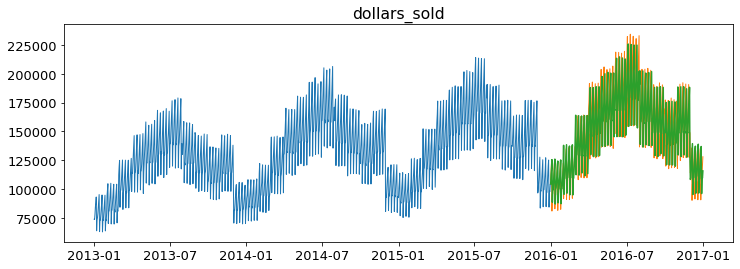

sales_diff -- RMSE: 449


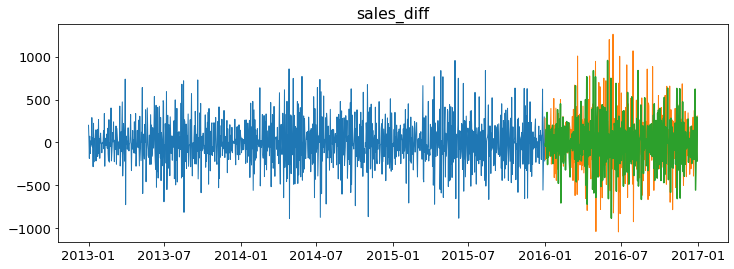

In [57]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)

<div class="alert alert-block alert-info"><b></b></div>

## Conclusion

Which model did the best?


In [58]:
dollars_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

items_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

s_diff_min_rmse = eval_df.groupby('target_var')['rmse'].min()[2]

# find which model that is
eval_df[((eval_df.rmse == dollars_min_rmse) | 
         (eval_df.rmse == items_min_rmse)   |
         (eval_df.rmse == s_diff_min_rmse))]

,model_type,target_var,rmse
5,simple_average,sales_diff,332.0
8,30d_moving_avg,sales_diff,332.0
11,1d_moving_avg,sales_diff,332.0
14,4d_moving_avg,sales_diff,332.0
17,12d_moving_avg,sales_diff,332.0
20,26d_moving_avg,sales_diff,332.0
23,52d_moving_avg,sales_diff,332.0
26,104d_moving_avg,sales_diff,332.0
30,previous_year,items_sold,5223.0
31,previous_year,dollars_sold,28087.0


Let's test it out on our out-of-sample data

We will be using train + validate to predict test

In [59]:
yhat_df = validate + train.diff(365).mean()
yhat_df.index = test.index

In [60]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [63]:
rmse_dollars = sqrt(mean_squared_error(test['dollars_sold'], 
                                       yhat_df['dollars_sold']))

rmse_items = sqrt(mean_squared_error(test['items_sold'], 
                                       yhat_df['items_sold']))

rmse_s_diff = sqrt(mean_squared_error(test['sales_diff'],
                                       yhat_df['sales_diff']))

In [65]:
print('rmse-dollars_sold: ', rmse_dollars)
print('rmse-items_sold: ', rmse_items)
print('rmse_s_diff:' , rmse_s_diff)

rmse-dollars_sold:  27114.786014988113
rmse-items_sold:  5040.989142541608
rmse_s_diff: 514.830259528001


`**Preformed Better on Test then on Validate**`

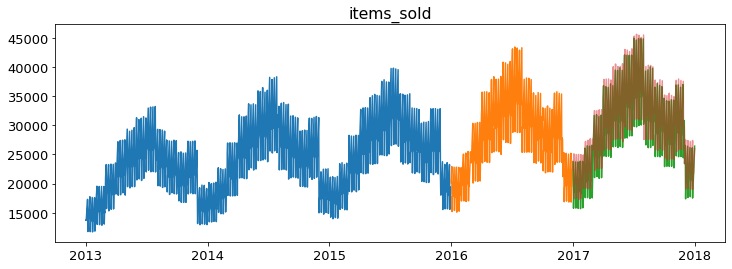

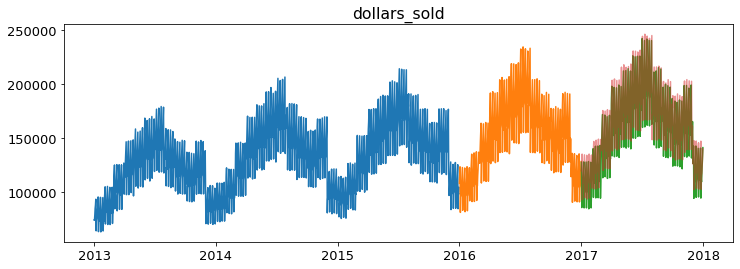

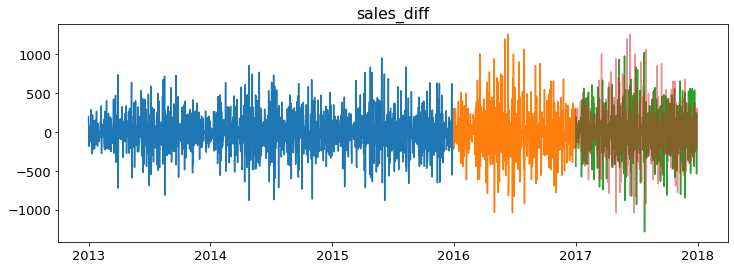

In [66]:
for col in train.columns:
    final_plot(col)

<div class="alert alert-block alert-info"><b></b></div>

## Future Predictions: (Next Unknown Year)

In [67]:
# to predict 2018

yhat_df = test + train.diff(365).mean()
yhat_df.index = test.index + pd.Timedelta('1Y')

In [68]:
yhat_df.head()

,items_sold,dollars_sold,sales_diff
sale_date,,,
2018-01-01 05:49:12+00:00,25894.813699,139013.960493,-443.314068
2018-01-02 05:49:12+00:00,17957.813699,97081.230493,194.205932
2018-01-03 05:49:12+00:00,20835.813699,112140.900493,-113.264068
2018-01-04 05:49:12+00:00,20695.813699,111205.840493,91.315932
2018-01-05 05:49:12+00:00,22080.813699,119365.050493,-134.664068


In [69]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

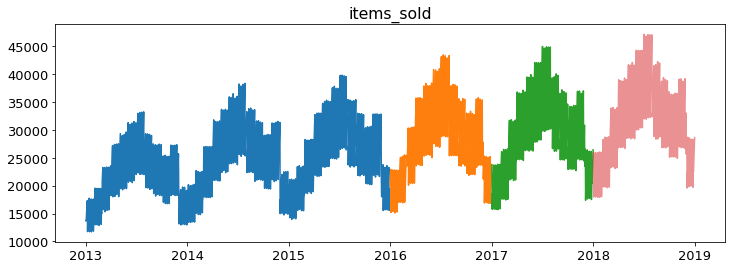

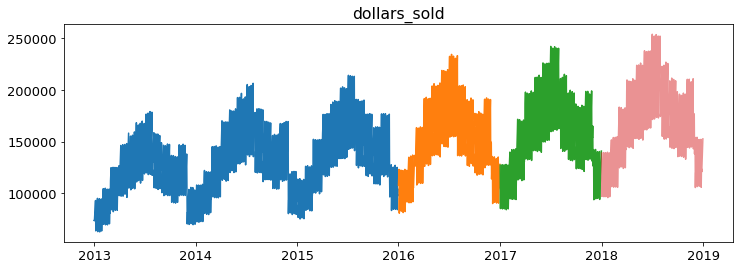

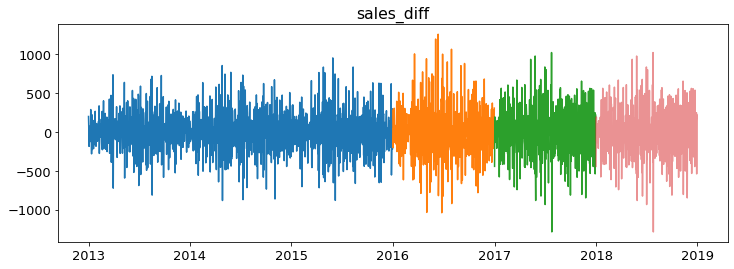

In [70]:
for col in train.columns:
    final_plot(col)